# Lab #2 part 2 of 2: controllers that open cupboard doors

In this notebook, we will take a more careful look at controllers, which have been hitherto treated as a black box that generates torques ($\tau_{cmd}$) to drive the robot to desired configurations ($q_{ref}$). 

<p align="center" style="text-align: center">
   Figure 1: controller as a black box  
   <img src="./resources/controller.png" width="500">
</p>


## 1. Dynamics 
Almost every controller starts with writing down the equations of motion ($F=ma$) of the robot:
\begin{equation}
M(q)\ddot{q} + C(q, \dot{q}) + \tau_g(q) = \tau_{cmd} + \tau_{external}   \quad\quad\quad (1)
\end{equation}
- $q \in \mathbb{R}^7$ is the configuration, or joint angles of the iiwa arm.
- $\ddot{q}, \ddot{q} \in \mathbb{R}^7$ are the generalized velocities and accelerations. 
- $M(q) \in \mathbb{R}^{7\times 7}$ is the mass matrix, which depends on $q$.
- $C(q, \dot{q}) \in \mathbb{R}^7$ is the Coriolis forces. 
- $\tau_g(q) \in \mathbb{R}^7$ is the torque (generalized forces) generated by gravity.
- $\tau_{external}$ is the torque generated by external contact. It is zero if the robot is not making contact with the environment. 
- $\tau_{cmd}$ is the torque applied to the robot by the robot's motors. 

## 2. Tracking a trajectory $q_{ref}(t)$
What $\tau_{cmd}$ should the robot's motor generate in order to follow a reference trajectory $q_{ref}(t)$?

First, let's differentiate $q_{ref}(t)$ to get the reference velocity $\dot{q}_{ref}(t)$ and acceleration $\ddot{q}_{ref}(t)$. Then the desired joint acceleration can be calculated as
\begin{equation}
\ddot{q}_{des}(t) = K_p(q_{ref}(t) - q(t)) + K_d(\dot{q}_{ref}(t) - \dot{q}(t)) + \ddot{q}_{ref}(t) \quad\quad\quad (2)
\end{equation}
where $K_p$ and $K_d$ are positional(P) and derivative(D) gains. 

Assuming that the robot is not colliding with its environment ($\tau_{external} = 0$), a common choice for $\tau_{cmd}$, is given by
\begin{equation}
\tau_{cmd} = M(q)\ddot{q}_{des}(t) + C(q, \dot{q}) + \tau_g(q) \quad\quad\quad (3)
\end{equation}

Substituting Equation (3) into Equation (1) cancels out $C(q, \dot{q})$ and $\tau_g(q)$ on the left hand side, which leaves us with
\begin{equation}
M(q)\ddot{q} = M(q)\ddot{q}_{des}
\end{equation}
or 
\begin{equation}
\ddot{q} = \ddot{q}_{des} \quad\quad\quad (4)
\end{equation}
because the mass matrix $M(q)$ is positive definite, and thus invertible. Using a model of the robot to command a torque that cancels out the robot's own dynamics is known as **feedback linearization.**

Let's define $e(t) = q(t) - q_{ref}(t)$ as the tracking error, and substitute (2) into (4), we get
\begin{equation}
\ddot{e}(t) + K_d\dot{e}(t) + K_p e(t) = 0
\end{equation}
which is a second order differential equation. Choosing $K_d$ and $K_p$ appropriately ensures that $e(t)$ converges to 0. 


## 3. Controlling a real robot
However, direct control of joint torques is rarely available through industrial robotic arms' API. As an example, the kuka iiwa robots used in lab sessions only accept a `iiwa_position_command`($q_{ref}$) and a `iiwa_feedforward_torque_command` ($\tau_{ff}$). How the robot's controller generates $\tau_{cmd}$ by blending these two commands is truly a mystery, but we have a reasonably good guess, which is [documented by Russ](https://drake.mit.edu/doxygen_cxx/classdrake_1_1examples_1_1manipulation__station_1_1_manipulation_station.html) and repeated below: 
\begin{align}
\ddot{q}_{des} &= PID(q_{ref}(t)) \\
\tau_{cmd} &= M(q)\ddot{q}_{des} + C(q, \dot{q}) + \tau_g(q) + \tau_{ff} 
\end{align}

<p align="center" style="text-align: center">
   Figure 2: iiwa's controller structure, or so we think. 
   <img src="./resources/iiwa_controller.png" width="700">
</p>


## 4. Tasks
Previously you have done various tasks by repeatedly solving inverse kinematics. This time around, we'll be completing tasks by using Jacobians. Specifically, you'll be asked to open the left door of the cupboard in `ManipulationStation` by mapping velocities or Cartesian forces into joint torques with the help of Jacobians. As usual, there is a **Youtube video** that shows what needs to be done. Click on the figure below to watch it. 

<p align="center" style="text-align: center">
   Video: opening the left door with impedance control.  
   <a href="https://youtu.be/xfcz2xbBUw4"><img src="./resources/open_door.png" width="600"></a>
</p>

You might be wondering what those red bars in the video are. They are there because we've added contact force visualization to `MeshcatVisualizer`. Any contact force larger than 1N is displayed as a red cylinder, whose length is proportional to the magnitude of the contact force. A 1m-long cylinder represents 20N. Here's a [fun video](https://youtu.be/uH9KZgnDlu4) to watch if you are curious about what the contact forces look like in pset 3. 


## 5. Geometry of [`ManipulationStation`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1examples_1_1manipulation__station_1_1_manipulation_station.html)
<p align="center" style="text-align: center">
   Figure 3: Schematic diagram of frames and points in `ManipulationStation`. Frames are drawn in 2D for simplicity.  
   <img src="./resources/manip_station_schematic_diagram.png" width="500">
</p>

- W: world frame. 
- L: frame fixed to the cupboard left door. 
- C_left_hinge: the center of the hinge relative to frame L.
- C_handle: the center of the door handle relative to frame L. 
- L7: frame fixed to link 7 (last link) of the robot. 
- EE: frame fixed to the end effector of the robot, which is also fixed w.r.t. L7. 
- Q: a point fixed in frame EE (and L7). 

## 6. Geometric Jacobian
In [Drake's notation convention](https://drake.mit.edu/doxygen_cxx/group__multibody__notation__basics.html), geometric Jacobians are denoted by $J_v$. They map the robot's joint velocity ($\dot{q}$) to the angular velocity of a frame, and the Cartesian velocity of a point fixed to that frame. The tasks in this notebook are centered around using geometric Jacobians to map quantities between joint and Cartesian space. 

For the door opening problem, the robot is interacting with the door handle at point Q fixed in frame L7. As $J_v$ is by definition a mapping from joint to Cartesian velocities, the following equality holds:
\begin{equation}
\begin{pmatrix}
[^W\omega^{L7}]_W\\
[^W v_Q]_W
\end{pmatrix}
\quad =\quad
[^W{J_v}^{L7}_Q]_W
\quad
\dot{q}
\end{equation}
- $[^W\omega^{L7}]_W$ is the angular velocity of frame L7 relative to frame W, expressed in frame W. 
- $[^W v_Q]_W$ is the linear velocity of point Q (which is fixed in L7), expressed in frame W. 
- $[^W{J_v}^{L7}_Q]_W \in \mathbb{R}^{6 \times 7}$ (written as `Jv_WL7q` in code) is the geometric Jacobian of point Q which is fixed in frame L7, relative to frame W and expressed in frame W. 

In addition, the transpose of geometric Jacobians maps Cartesian forces/torques back to joint space: 
\begin{align}
[F^{L7}]_W
\quad &=\quad
\begin{pmatrix}
[\tau^{L7}]_W\\
[f^Q]_W
\end{pmatrix}\\
\dot{q}
\quad &=\quad
{[^W{J_v}^{L7}_Q]_W}^{\intercal}
\quad
[F^{L7}]_W
\end{align}
- $[F^{L7}]_W \in \mathbb{R}^6$ is the [spatial force](https://drake.mit.edu/doxygen_cxx/group__multibody__quantities.html) on body(frame) L7.
- $[\tau^{L7}]_W \in \mathbb{R}^3$ is the torque on body L7.
- $[f^Q]_W \in \mathbb{R}^3$ is the force at point Q, which is fixed to body L7. 

In [1]:
# Import stuff to be used in this notebook. Run this first!
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import meshcat
import meshcat.geometry as g
                                  
from manipulation_station_simulator import ManipulationStationSimulator
from run_manipulation_station_simulator import (GenerateIiwaPlansAndGripperSetPoints,
                                                PlotExternalTorqueLog, 
                                                PlotIiwaPositionLog)
                                            
from pydrake.common import FindResourceOrThrow
from robot_plans import * 

In [2]:
# First start meshcat for visualization - this only has to be run once.
# If you interrupt the kernel of this notebook, you'll need to run this cell again to 
# restart the meshcat server, and then refresh the visualization window. 
# This will open a mesh-cat server in the background, click on the url to display visualization in a separate window. 
vis = meshcat.Visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [ ]:
# Run this if you feel the visualizer is messed up and want to start over.
vis.delete()

## Getting started
We've provided you with `JointSpacePlan`s that 
1. move point Q in frame L7 to `C_handle`, 
2. close the gripper, and then
3. open the left door by tracking a joint-space trajectory.

In [1]:
# Construct a ManipulationStation
object_file_path = FindResourceOrThrow(
        "drake/examples/manipulation_station/models/061_foam_brick.sdf")

manip_station_sim = ManipulationStationSimulator(
    time_step=2e-3,
    object_file_path=object_file_path,
    object_base_link_name="base_link",
    is_hardware=False)

# Generate plans.
q0 = [0, 0, 0, -1.75, 0, 1.0, 0]
plan_list, gripper_setpoint_list = \
    GenerateIiwaPlansAndGripperSetPoints(manip_station_sim, q0)

# Run simulation
iiwa_position_command_log, iiwa_position_measured_log, iiwa_external_torque_log, \
        wsg_state_log, wsg_command_log = \
    manip_station_sim.RunSimulation(plan_list, gripper_setpoint_list,
                                extra_time=2.0, real_time_rate=1.0, q0_kuka=q0)

NameError: name 'FindResourceOrThrow' is not defined

The following cell plots the external torque sensed by each joint of the robot. The external torques should be zero when there's no external contact. Note that the final value of the torques are not zero. 

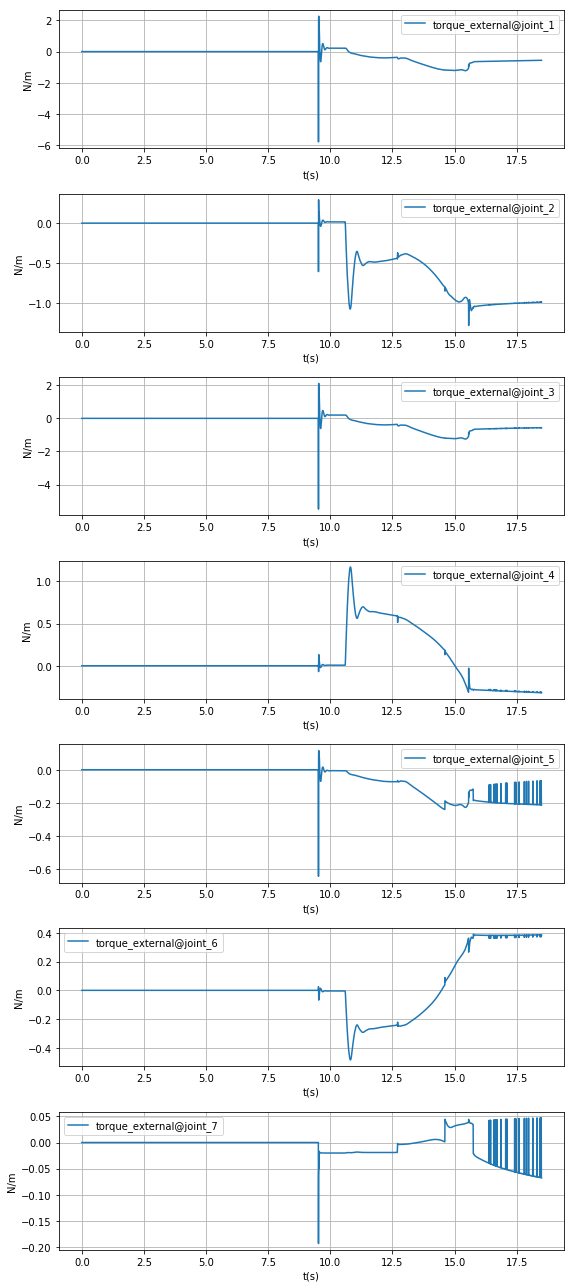

In [4]:
PlotExternalTorqueLog(iiwa_external_torque_log)

We also have a plot function for commanded and actual joint angles. 

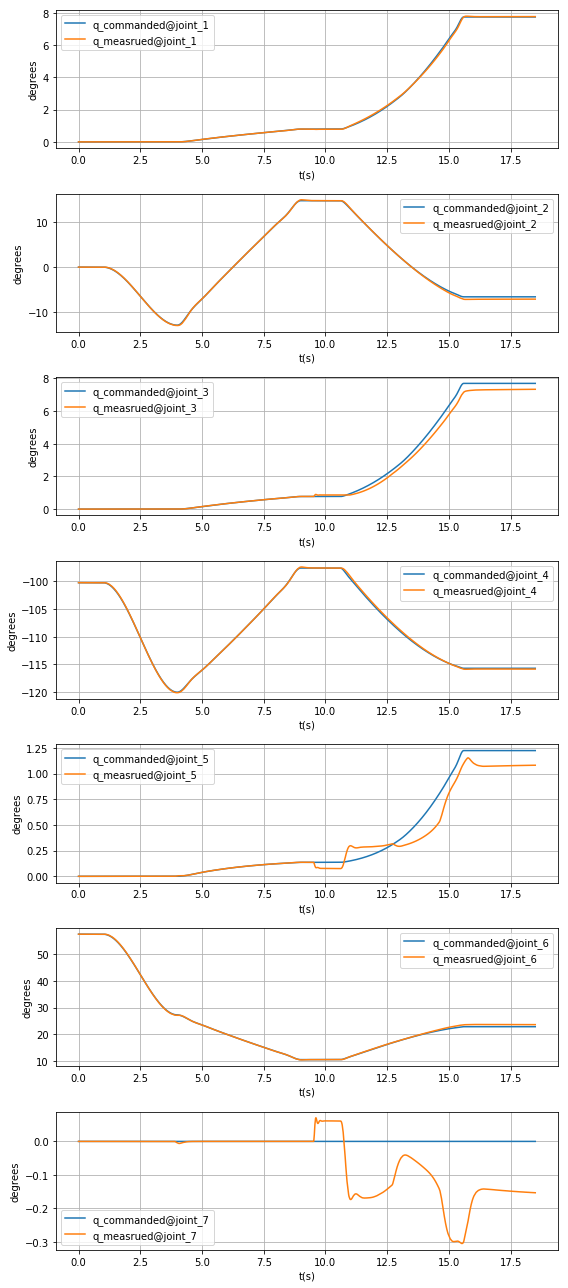

In [5]:
PlotIiwaPositionLog(iiwa_position_command_log, iiwa_position_measured_log)

## Task 1: Define a task frame.
Find a "task frame" $H_r$ in which the position errors are measured. Its origin should be coincident with the center of the left door handle. And point $Q$ in frame L7 should be tracking this the origin of $H_r$. Hint: page 5 of [De Luca's slides on hybrid force/position control](http://www.diag.uniroma1.it/~deluca/rob2_en/16_HybridControl.pdf).

The class `OpenLeftDoorPlan` in `robot_plan.py` constructs a cubic polynomial from `angle_start` to `angle_end`. Note that the door angle is defined as the angle between the world y-axis and the line that connects `C_left_hinge` and `C_handle`, as shown in Figure 3.

Complete `OpenLeftDoorPlan.CalcKinematics` to define the task frame $H_r$. It should be a function of the door angle. 

## Task 2: Open the door by mapping velocities.
For simplicity, we'll ignore orientation errors and only consider translation errors (the position of point Q relative to $H_r$, or its additive inverse). Choose a 3 by 3 diagonal gain matrix $\alpha$ that is soft in the direction of natural constraints. Mathematically, the controller should look like:
\begin{align}
e &=
\begin{pmatrix}
0 \\
\alpha e_{xyz}
\end{pmatrix}\\
\dot{q}_{des} &= {[^W{J_v}^{L7}_Q]_W}^{+} e \\
q_{ref} &= q_{current} + \dot{q}_{des} \Delta t \\
\tau_{ff} &= 0 
\end{align}
- ${[^W{J_v}^{L7}_Q]_W}^{+}$ is the pseudo inverse of $[^W{J_v}^{L7}_Q]_W$
- $\Delta t$ is the controller time step, which is 5ms by default. 

Complete `OpenLeftDoorPositionPlan.CalcPositionCommand` in `robot_plan.py` with the controller described above. 

In [4]:
# Construct a ManipulationStation
object_file_path = FindResourceOrThrow(
        "drake/examples/manipulation_station/models/061_foam_brick.sdf")

manip_station_sim = ManipulationStationSimulator(
    time_step=2e-3,
    object_file_path=object_file_path,
    object_base_link_name="base_link",
    is_hardware=False)

# Generate plans.
q0 = [0, 0, 0, -1.75, 0, 1.0, 0]
plan_list, gripper_setpoint_list = \
    GenerateIiwaPlansAndGripperSetPoints(manip_station_sim, q0)

# Replace the trajectory-based plan with your position/impedance plan.
plan_list[-1] = OpenLeftDoorPositionPlan(
    angle_start=theta0_hinge, angle_end=np.pi/4, duration=6.0)

# Run simulation
iiwa_position_command_log, iiwa_position_measured_log, iiwa_external_torque_log, \
        wsg_state_log, wsg_command_log = \
    manip_station_sim.RunSimulation(plan_list, gripper_setpoint_list,
                                extra_time=2.0, real_time_rate=1.0, q0_kuka=q0)

SolutionResult.kSolutionFound
0 :  SolutionResult.kSolutionFound
1 :  SolutionResult.kSolutionFound
2 :  SolutionResult.kSolutionFound
3 :  SolutionResult.kSolutionFound
4 :  SolutionResult.kSolutionFound
5 :  SolutionResult.kSolutionFound
6 :  SolutionResult.kSolutionFound
7 :  SolutionResult.kSolutionFound
8 :  SolutionResult.kSolutionFound
9 :  SolutionResult.kSolutionFound
0 :  SolutionResult.kSolutionFound
1 :  SolutionResult.kSolutionFound
2 :  SolutionResult.kSolutionFound
3 :  SolutionResult.kSolutionFound
4 :  SolutionResult.kSolutionFound
5 :  SolutionResult.kSolutionFound
6 :  SolutionResult.kSolutionFound
7 :  SolutionResult.kSolutionFound
8 :  SolutionResult.kSolutionFound
9 :  SolutionResult.kSolutionFound
10 :  SolutionResult.kSolutionFound
11 :  SolutionResult.kSolutionFound
12 :  SolutionResult.kSolutionFound
13 :  SolutionResult.kSolutionFound
14 :  SolutionResult.kSolutionFound
15 :  SolutionResult.kSolutionFound
16 :  SolutionResult.kSolutionFound
17 :  SolutionResu

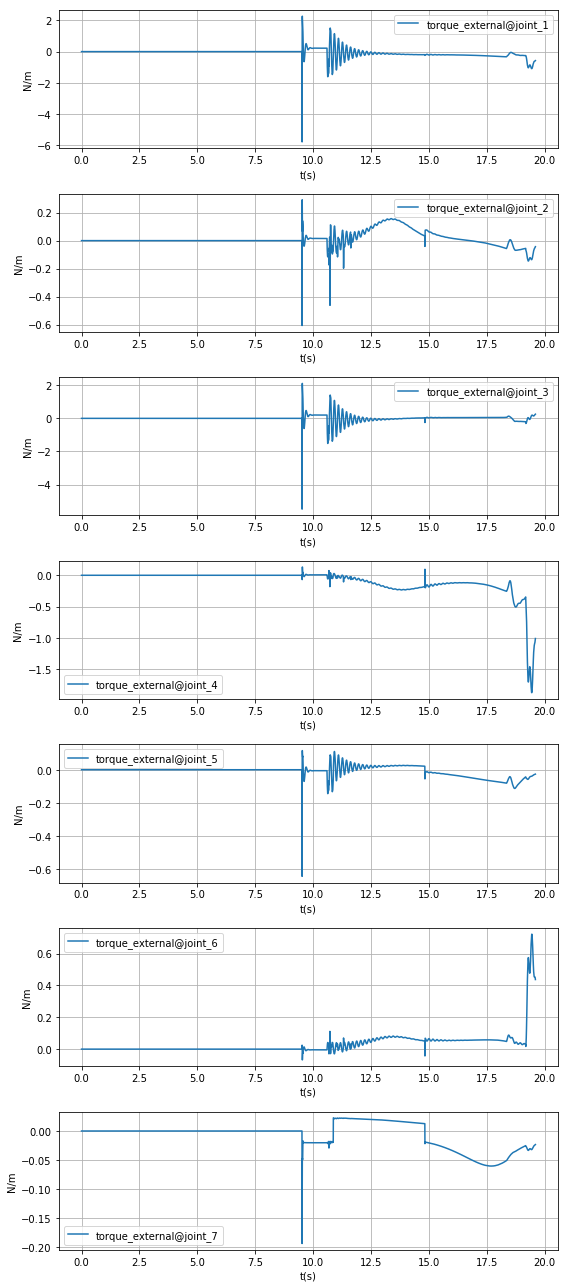

In [5]:
# Plot external torque
PlotExternalTorqueLog(iiwa_external_torque_log)

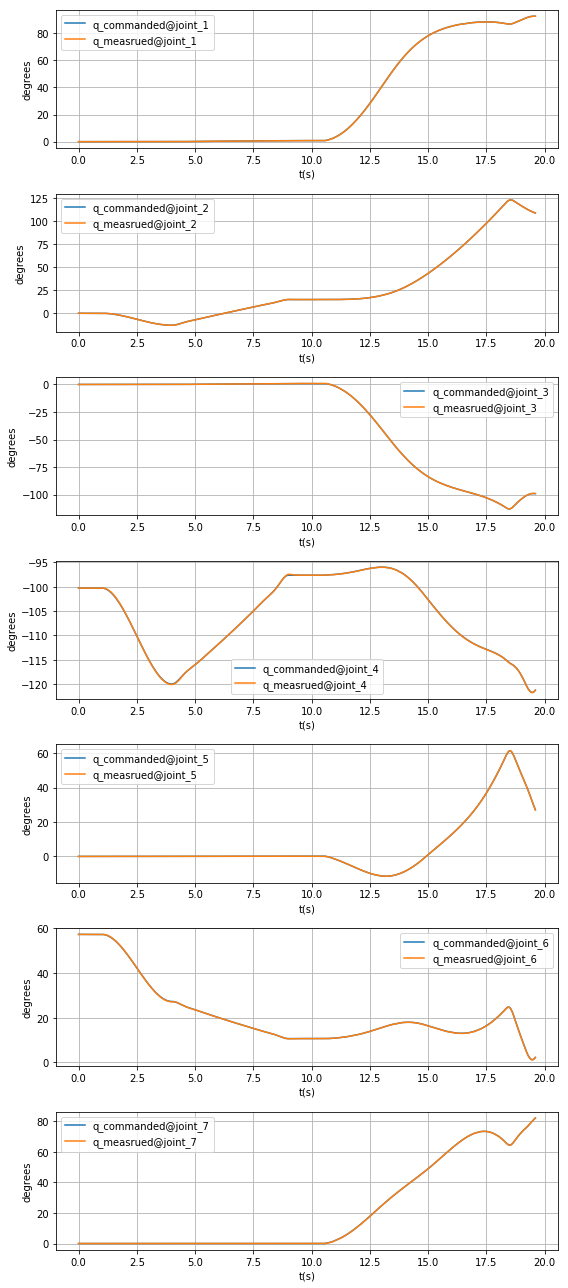

In [6]:
# Plot commanded and actual position.
PlotIiwaPositionLog(iiwa_position_command_log, iiwa_position_measured_log)

## Task 3: Open the door by mapping forces.
It is also possible to send feedforward torque command, and bypass the position command by sending the current position of the robot as position command:
\begin{align}
e &=
\begin{pmatrix}
0 \\
\beta e_{xyz}
\end{pmatrix}\\
\tau_{ff} &= {[^W{J_v}^{L7}_Q]_W}^{\intercal} e \\
q_{ref} &= q_{current}
\end{align}
where $\beta$ is also a 3 by 3 diagonal matrix, which should be different from $\alpha$.

Complete `OpenLeftDoorImpedancePlan.CalcTorqueCommand` in `robot_plan.py` with the controller described above. 

In [3]:
# Construct a ManipulationStation
object_file_path = FindResourceOrThrow(
        "drake/examples/manipulation_station/models/061_foam_brick.sdf")

manip_station_sim = ManipulationStationSimulator(
    time_step=2e-3,
    object_file_path=object_file_path,
    object_base_link_name="base_link",
    is_hardware=False)

# Generate plans.
q0 = [0, 0, 0, -1.75, 0, 1.0, 0]
plan_list, gripper_setpoint_list = \
    GenerateIiwaPlansAndGripperSetPoints(manip_station_sim, q0)

# Replace the trajectory-based plan with your position/impedance plan.
plan_list[-1] = OpenLeftDoorImpedancePlan(
    angle_start=theta0_hinge, angle_end=np.pi/4, duration=6.0)

# Run simulation
iiwa_position_command_log, iiwa_position_measured_log, iiwa_external_torque_log, \
        wsg_state_log, wsg_command_log = \
    manip_station_sim.RunSimulation(plan_list, gripper_setpoint_list,
                                extra_time=2.0, real_time_rate=1.0, q0_kuka=q0)

SolutionResult.kSolutionFound
0 :  SolutionResult.kSolutionFound
1 :  SolutionResult.kSolutionFound
2 :  SolutionResult.kSolutionFound
3 :  SolutionResult.kSolutionFound
4 :  SolutionResult.kSolutionFound
5 :  SolutionResult.kSolutionFound
6 :  SolutionResult.kSolutionFound
7 :  SolutionResult.kSolutionFound
8 :  SolutionResult.kSolutionFound
9 :  SolutionResult.kSolutionFound
0 :  SolutionResult.kSolutionFound
1 :  SolutionResult.kSolutionFound
2 :  SolutionResult.kSolutionFound
3 :  SolutionResult.kSolutionFound
4 :  SolutionResult.kSolutionFound
5 :  SolutionResult.kSolutionFound
6 :  SolutionResult.kSolutionFound
7 :  SolutionResult.kSolutionFound
8 :  SolutionResult.kSolutionFound
9 :  SolutionResult.kSolutionFound
10 :  SolutionResult.kSolutionFound
11 :  SolutionResult.kSolutionFound
12 :  SolutionResult.kSolutionFound
13 :  SolutionResult.kSolutionFound
14 :  SolutionResult.kSolutionFound
15 :  SolutionResult.kSolutionFound
16 :  SolutionResult.kSolutionFound
17 :  SolutionResu

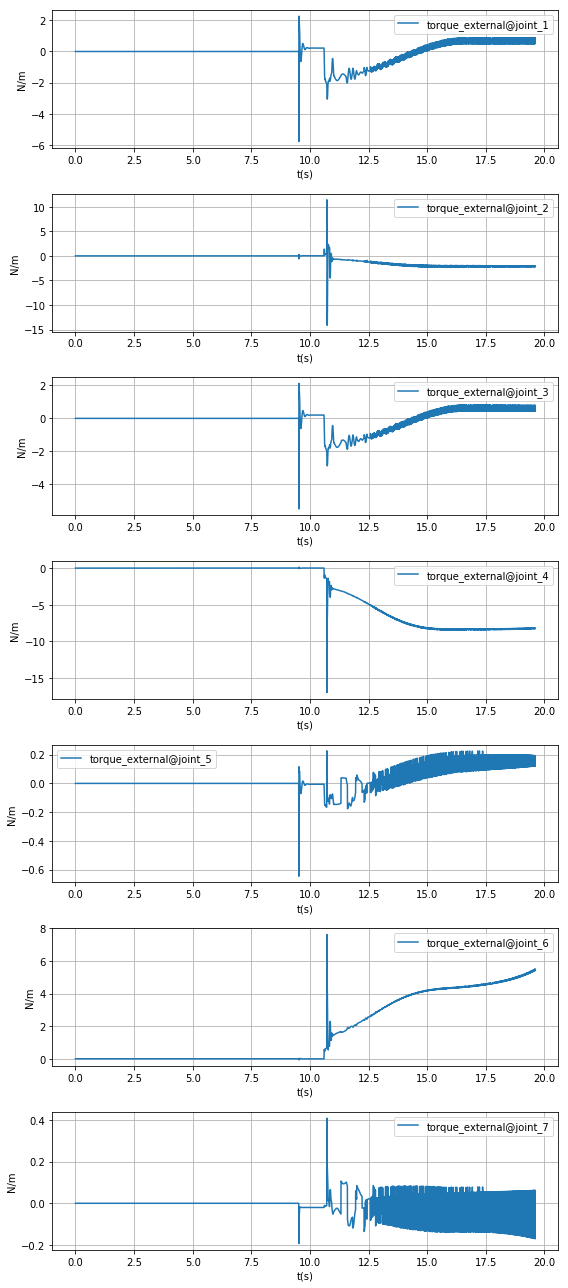

In [4]:
# Plot external torque
PlotExternalTorqueLog(iiwa_external_torque_log)

In [ ]:
# Plot commanded and actual position.
PlotIiwaPositionLog(iiwa_position_command_log, iiwa_position_measured_log)